In [2]:
import os
import numpy as np
from pyplr import utils
import pandas as pd
from classPLRfromGitHub import PLR
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import simpledialog
import sys
import importlib
import checkdataPLR
#from preprocessing import ProcessConfig

In [3]:

# Define the subject_id
subject_id = 'PJ01_1_PLR1'

# Load the CSV file
if os.getlogin()=='marco':
    rec_dir = f"/home/marco/Nextcloud/KatharinaBeispieldaten/{subject_id[:4]}/{subject_id}/"
else:
    rec_dir = f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/"

utils.print_file_structure(rec_dir)

/
    PLR_left_2d_results.csv
    PLR_left_3d_results.csv
    PLR_right_2d_results.csv
    PLR_right_3d_results.csv
    annotation_timestamps.npy
exports/
    000/
        annotations.csv
        export_info.csv
        gaze_positions.csv
        pupil_gaze_positions_info.txt
        pupil_positions.csv
        pupil_positions.csv.pickle
pyplr_analysis/
    PLR_left_2d_results.csv


In [28]:
# assign the 4 light strenghts
Light_strenght_1 = 1
Light_strenght_2 = 2
Light_strenght_3 = 3
Light_strenght_4 = 4

# Sampling frequency, 120 Hertz per second
SAMPLE_RATE = 120

# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter']

pupil_cols_in = ['diameter']
pupil_cols_out = ['diameter_interp']

# Check if the pyplr_analysis directory exists
if not os.path.exists(os.path.join(rec_dir, 'pyplr_analysis')):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.join(rec_dir, 'pyplr_analysis'))

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')


************************************************************
*****************************  *****************************
************************************************************


In [29]:

#eye_id=best takes the eye with the best confidence, eye_id=0 takes right, 1 takes left
samples = utils.load_pupil(
    s['data_dir'], eye_id='left', method='2d', cols=use_cols)
samples

# load the pupil data for the current combination of eye_id and method
samples = utils.load_pupil(s['data_dir'], eye_id='left', method='2d', cols=use_cols)


Loaded 8807 samples
Loaded 8807 samples


In [30]:
importlib.reload(checkdataPLR)

# Let's try to remove blinks and filter the result

#what=eye0[0]


# Iterate over the specified data frames
!pip install fastnumbers
!pip install datamatrix
import datamatrix
import datamatrix.series
import datamatrix.operations

def blinkreconstruct(df, vt=5, vt_start=10, vt_end=5, maxdur=800, margin=20, smooth_winlen=21, std_thr=3, gap_margin=20, gap_vt=10, mode=u'advanced'):
    import datamatrix
    import datamatrix.series
    import datamatrix.operations
    dm=datamatrix.convert.from_pandas(df) #.series
    return datamatrix.series.blinkreconstruct(dm,vt,vt_start,vt_end,maxdur,margin,smooth_winlen,std_thr,gap_margin,gap_vt,mode)


/home/marco/Projects/KatharinaMeier/Pupille/venv/lib/python3.10/site-packages/datamatrix/py3compat.py:105: UserWarning: smooth only accepts 1 dimension arrays
  warnings.warn(safe_str(msg), *args)


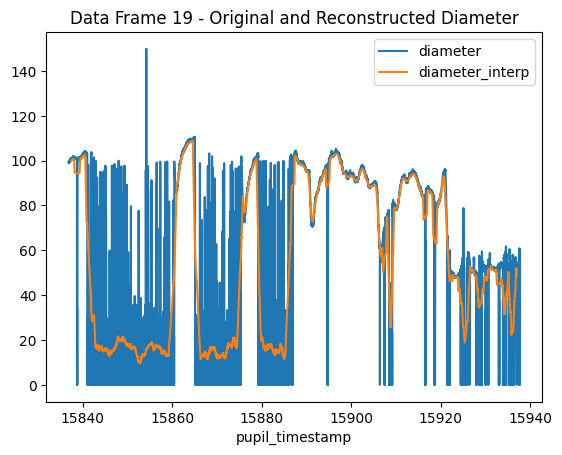

In [32]:

eye=samples

def reconstruct(eye, col_in, col_out, window_size=100):
    col_interp=f'{col_out}_interp'
    interpolated=eye[col_in].interpolate(method='linear')
    eye[col_out] = blinkreconstruct(interpolated,
                                    vt_start=10 / 1, vt_end=5 / 1, maxdur=800,
                                    mode='advanced')
    plot_all = {
    99: True  # Specify the index of the data frame you want to plot
}
    eye[f'{col_interp}']=eye[f'{col_out}'].interpolate(method='linear')
    # Use moving average + recenter as low pass.
    eye[f'{col_out}']=eye[f'{col_interp}'].rolling(window=window_size).mean().shift(-window_size//2)


for col_in,col_out in zip(pupil_cols_in,pupil_cols_out): 
    reconstruct(eye, col_in, col_out)

sub = eye.plot(x='pupil_timestamp', y='diameter', kind='line')
sub = eye.plot(ax=sub, x='pupil_timestamp', y='diameter_interp', kind='line')
sub.set_title(f"Data Frame {i} - Original and Reconstructed Diameter")
plt.show()



Loaded 4 events


,index,label,duration
timestamp,,,
15860.012292,692,LIGHT_ON,NaN
15875.191991,1145,LIGHT_ON,NaN
15890.376046,1598,LIGHT_ON,NaN
15905.591962,2052,LIGHT_ON,NaN


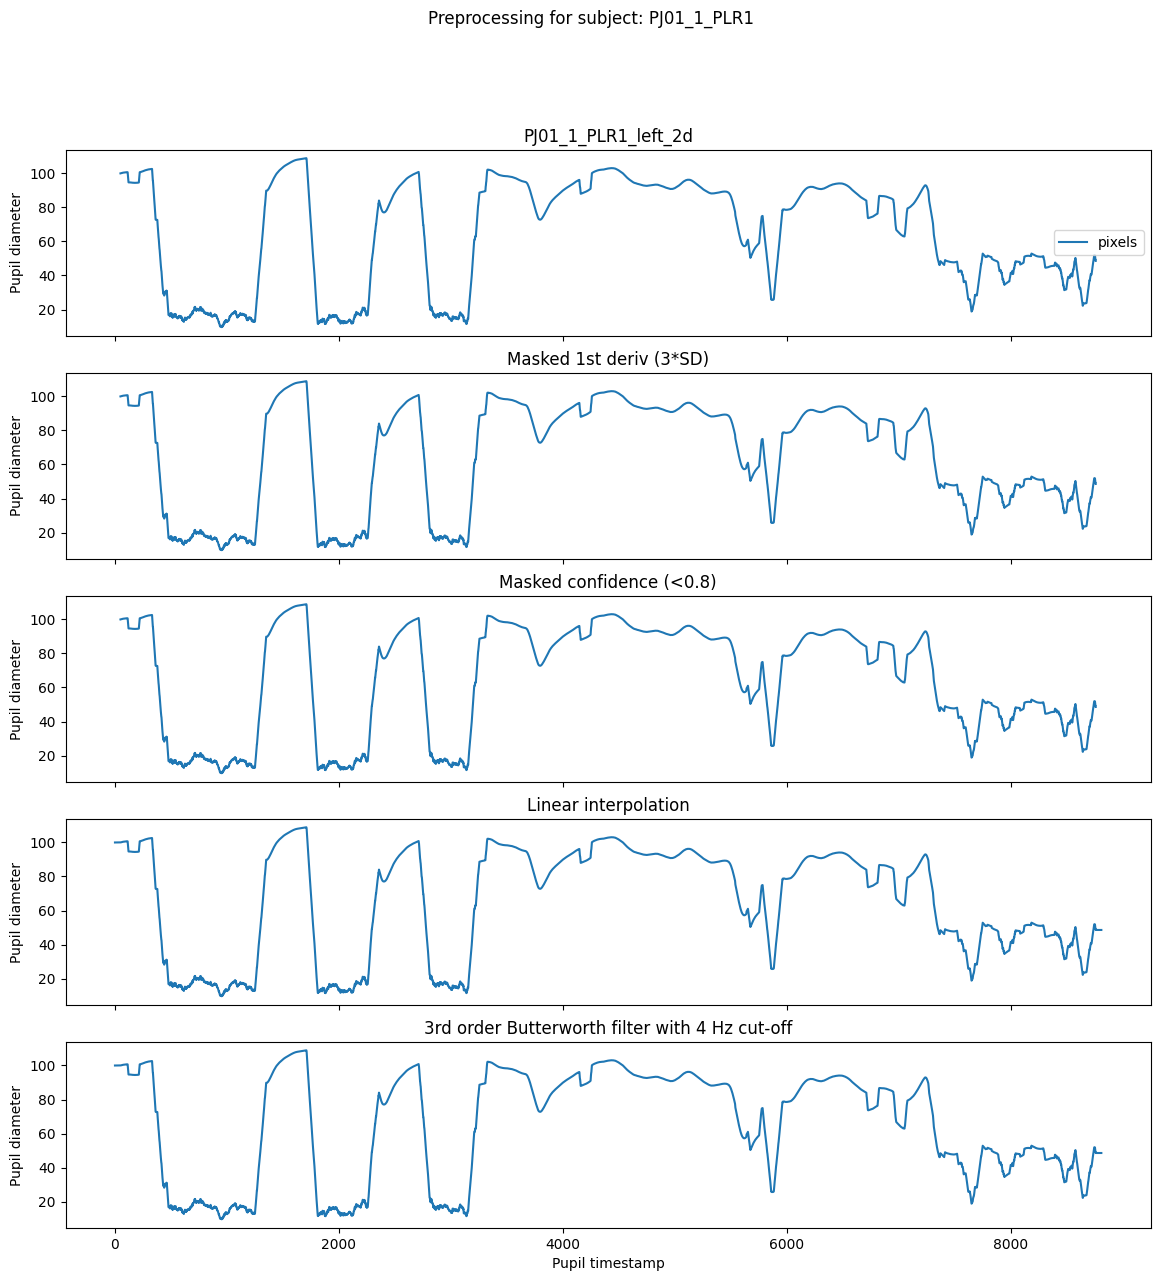

In [33]:
# Make figure for processing, append figure to pupil_preprocessing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=f"{subject_id}" )

# Plot the raw data
samples[pupil_cols_out].plot(title=f"{subject_id}_left_2d", ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['pixels'])
# Mask first derivative
# Default is a threshold of 3 SD from the mean first derivate
# If there are a lot of blinks the mean first derivate is higher
# Therefore set the threshold lower 
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols_out].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols_out].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)
 
# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols_out)
samples[pupil_cols_out].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols_out].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

events = utils.load_annotations(s['data_dir'])
events


In [16]:
# Number of samples to extract and which sample should mark the onset of the event
# 120 data points equal one second with a sample rate of 120 
# Real duration is Duration-ONSET_IDX
#ONSET_IDX is the time before light stimulus that gets sampled 

DURATION = 1200 #10s
ONSET_IDX = 120 #0 until 120' baseline, start point PLR at 120, 120 = 0seconds

# Extract the event ranges, gets range of total duration (1200) and shifts the onset_idx to the left in time, therefore 120 is the 0 point
# samples = containing all data
# events = pupil_timestamps of annotations (start PLR)
# offset = defines the PLR starting time

ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])

# Convert data to numeric format
ranges = ranges.apply(pd.to_numeric, errors='coerce')

# Calculate baselines, the time before the onset is 0 to 120
baselines = ranges.loc[:, range(0, ONSET_IDX), :].groupby(level=0, axis=1).mean()

# New columns for percent signal change, simply adds 2 new columns with percent change
ranges = preproc.percent_signal_change(
    ranges, baselines, pupil_cols)
ranges


print(ranges.loc[0:3])

#s Seperate the four light stamps that the data of each has its own table
ranges1 = ranges.loc[0]
ranges2 = ranges.loc[1]
ranges3 = ranges.loc[2]
ranges4 = ranges.loc[3]

print(ranges4)


Extracted ranges for 4 events
             eye_id  confidence   diameter  method  interpolated   
event onset                                                        
0     0           1    0.572564  27.547325     NaN             1  \
      1           1    0.000000  27.561876     NaN             1   
      2           1    0.591773  27.579335     NaN             1   
      3           1    0.671322  27.600134     NaN             1   
      4           1    0.721295  27.624648     NaN             1   
...             ...         ...        ...     ...           ...   
3     1195        1    0.728679  91.162693     NaN             1   
      1196        1    0.824552  91.099156     NaN             0   
      1197        1    0.745241  91.041220     NaN             1   
      1198        1    0.887581  90.988648     NaN             0   
      1199        1    0.873877  90.941048     NaN             0   

                 orig_idx  color  diameter_pc  
event onset                          

,value
Baseline,89.207081
Latency_a,0.091667
Latency_b,0.375000
T2MaxVel,1.758333
T2MaxCon,3.208333
T2Rec75pc,0.291667
PeakCon,14.969830
ConAmplitude,74.237250
VelConMax,451.583665
VelConAve,76.300840


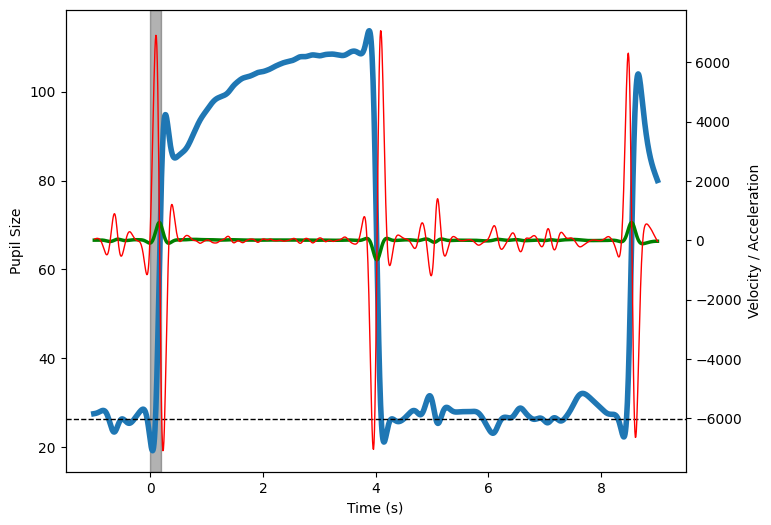

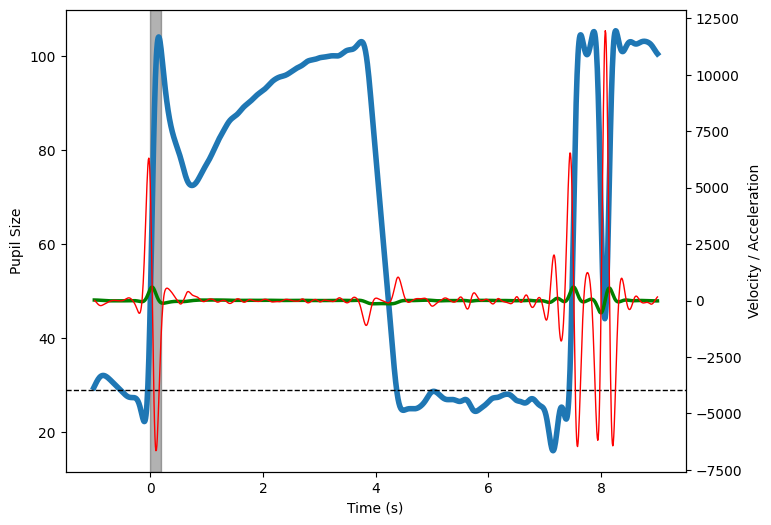

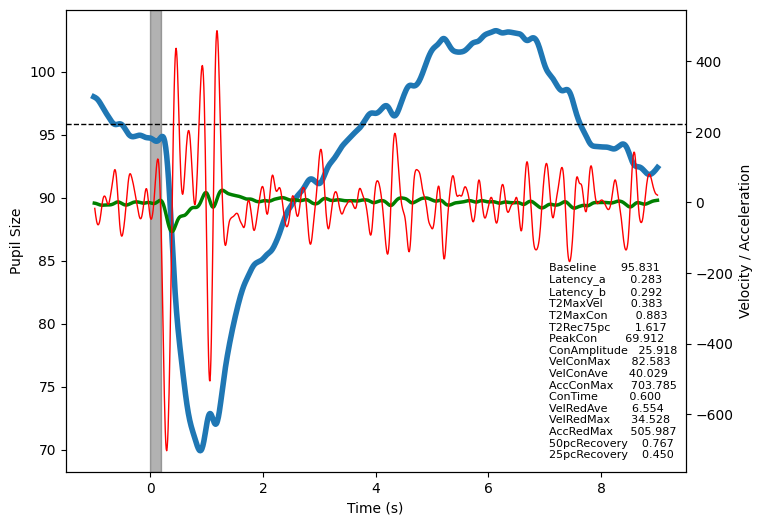

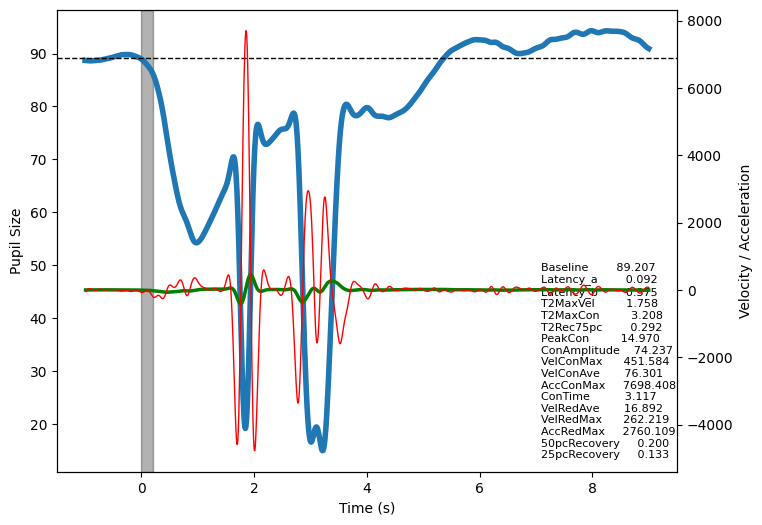

In [18]:
# Function for plotting data
# Box in grey: duration of light stimulus

def get_average_plr(input_range):
    average_plr = input_range.groupby(level=0)['diameter'].mean().to_numpy()
    return PLR(average_plr,
              sample_rate=SAMPLE_RATE,
              onset_idx=ONSET_IDX,
              stim_duration=0.2)

plr1 = get_average_plr(ranges1)
plr2 = get_average_plr(ranges2)
plr3 = get_average_plr(ranges3)
plr4 = get_average_plr(ranges4)

plr_all = [plr1, plr2, plr3, plr4]


#plot graphs for diameter = in blue, vel = velocity in green, acc = acceleration in red and parameters
fig1 = plr1.plot(vel=True, acc=True, print_params=True)
fig2 = plr2.plot(vel=True, acc=True, print_params=True)
fig3 = plr3.plot(vel=True, acc=True, print_params=True)
fig4 = plr4.plot(vel=True, acc=True, print_params=True)

# Prints results
params1 = plr1.parameters()
params1

params2 = plr2.parameters()
params2

params3 = plr3.parameters()
params3

params4 = plr4.parameters()
params4



In [30]:
# Function to define results, exact definitions in classPLRfromGithub
# separate results für every PLR
def get_pyplr_results(plr):
#D1 = baseline pupilsize, in mm
    D1 = plr.baseline()
    print("D1: ",D1)
    
    #D2 = minimum pupilsize, in mm 
    D2 = plr.peak_constriction()
    print("D2: ",D2)
    
    #AMP = constriction amplitude, in mm
    AMP = D1-D2
    print("AMP: ",AMP)
    
    #VCmax = maximum velocity of constriction, in mm/s
    VCmax = plr.max_constriction_velocity()
    print("VCmax: ",VCmax)
    
    #ACmax = maximum acceleration, in mm/s ?
    ACmax = plr.max_constriction_acceleration()
    print("ACmax: ",ACmax)
    
    #T1 = latency from the onset of the light stimulus to the maximum acceleration
    # in milliseconds - looks like in seconds on the graph  
    T1 = plr.latency_to_constriction_b()
    print("T1: ",T1)
    
    #T2 = time to maximum velocity, looks like in seconds on the graph 
    T2 = plr.time_to_max_velocity()
    print("T2: ",T2)
    
    #T3 = time to maximum constriction, in milliseconds - looks like in seconds on graph 
    T3 = plr.time_to_max_constriction()
    print("T3: ",T3)
    
    #relative constriction amplitude: AMP/D1
    rel_AMP = AMP/D1
    print("rel_AMP: ", rel_AMP)
    
    #time to 75% redilation 
    redil_75 = plr.time_to_75pc_recovery()
    print("redil_75", redil_75)
    
    #time to 50% redilation
    redil_50 = plr.time_to_50pc_recovery()
    print('redil_50', redil_50)
    
    redil_25 = plr.time_to_25pc_recovery()
    print('redil_25', redil_25)
    
    # create a CSV file
    return {
            'D1':D1,
            'D2': D2,
            'AMP': AMP,
            'VCmax':VCmax,
            'ACmax': ACmax,
            'T1': T1,
            'T2':T2,
            'T3':T3,
            "rel_AMP": rel_AMP,
            "redil_75": redil_75,
            'redil_50': redil_50,
            'redil_25': redil_25
            }

pyplr_results = {'Subject ID': [subject_id, subject_id, subject_id, subject_id],
                 'D1':[],
                 'D2':[],
                 'AMP': [],
                 'VCmax':[],
                 'ACmax': [],
                 'T1': [],
                 'T2':[],
                 'T3':[],
                 "rel_AMP": [],
                 "redil_75": [],
                 'redil_50': [],
                 'redil_25': [],
                 'Light_strenght': [Light_strenght_1, Light_strenght_2, Light_strenght_3, Light_strenght_4]}


In [31]:
# dictionary to store results from pyplr_results_function
plr_all = [plr1, plr2, plr3, plr4]

for plr in plr_all:
    pyplr_result = get_pyplr_results(plr)
    pyplr_results["D1"].append(pyplr_result["D1"])
    pyplr_results["D2"].append(pyplr_result["D2"])
    pyplr_results["AMP"].append(pyplr_result["AMP"])
    pyplr_results["VCmax"].append(pyplr_result["VCmax"])
    pyplr_results["ACmax"].append(pyplr_result["ACmax"])
    pyplr_results["T1"].append(pyplr_result["T1"])
    pyplr_results["T2"].append(pyplr_result["T2"])
    pyplr_results["T3"].append(pyplr_result["T3"])
    pyplr_results["rel_AMP"].append(pyplr_result["rel_AMP"])
    pyplr_results["redil_75"].append(pyplr_result["redil_75"])
    pyplr_results["redil_50"].append(pyplr_result["redil_50"])
    pyplr_results["redil_25"].append(pyplr_result["redil_25"])




D1:  26.914498395876386
D2:  19.68401174238123
AMP:  7.230486653495156
VCmax:  98.76530104819821
ACmax:  2687.3331901735073
T1:  0.225
T2:  4.016666666666667
T3:  0.041666666666666664
rel_AMP:  0.2686465319599993
redil_75 0.05
redil_50 0.041666666666666664
redil_25 0.03333333333333333
D1:  29.66635953747131
D2:  16.67499288856175
AMP:  12.991366648909558
VCmax:  595.6268797898923
ACmax:  6665.02964750407
T1:  0.1
T2:  7.991666666666666
T3:  7.141666666666667
rel_AMP:  0.43791576895372963
redil_75 0.275
redil_50 0.1
redil_25 0.06666666666666667
D1:  96.38226286787788
D2:  70.54484931122445
AMP:  25.83741355665343
VCmax:  82.26567617405124
ACmax:  670.0094755240798
T1:  0.2916666666666667
T2:  0.39166666666666666
T3:  0.8833333333333333
rel_AMP:  0.2680722862055201
redil_75 1.6166666666666667
redil_50 0.7833333333333333
redil_25 0.4583333333333333
D1:  89.6657031772002
D2:  15.616532912126097
AMP:  74.04917026507411
VCmax:  447.02632962626353
ACmax:  7620.014464619686
T1:  0.375
T2:  1.7

In [32]:
# Converts results to dataframe
df = pd.DataFrame(pyplr_results)
df["eye_id"] = "1"
df["method"] = "2d"


#always change the directory to what the sample gets saved 
df.to_csv(f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/pyplr_analysis/PLR_left_2d_results.csv", index=False)

print(df)


    Subject ID         D1         D2        AMP       VCmax        ACmax  \
0  PJ01_1_PLR1  26.914498  19.684012   7.230487   98.765301  2687.333190   
1  PJ01_1_PLR1  29.666360  16.674993  12.991367  595.626880  6665.029648   
2  PJ01_1_PLR1  96.382263  70.544849  25.837414   82.265676   670.009476   
3  PJ01_1_PLR1  89.665703  15.616533  74.049170  447.026330  7620.014465   

         T1        T2        T3   rel_AMP  redil_75  redil_50  redil_25  \
0  0.225000  4.016667  0.041667  0.268647  0.050000  0.041667  0.033333   
1  0.100000  7.991667  7.141667  0.437916  0.275000  0.100000  0.066667   
2  0.291667  0.391667  0.883333  0.268072  1.616667  0.783333  0.458333   
3  0.375000  1.758333  3.208333  0.825836  0.291667  0.200000  0.133333   

   Light_strenght eye_id method  
0               1      1     2d  
1               2      1     2d  
2               3      1     2d  
3               4      1     2d  
